# Deep learning

A deep neural network (multilayer perceptron, MLP) will be used to classify audio recordings as either urban or natural environments. The following plans have been made:

1. I will use the BayesianOptimization hyperparameter tuning procedure to search for the best depth of the model, number of units at each layer, learning rate, and activation function.
2. To avoid overfitting, a dropout layer will be inserted between any two layers, and the dropout rate will also be tuned.
3. Since pre-trained CNN models such as VGGish, YAMNet, and PANNs may represent similar information, I will only use the embeddings of one model at a time, along with features of soundscape indices and the spectrotemporal modulation spectrum.
4. I will train a deep neural network on the features of each of the raw, background (bg), and foreground (fg) signals, as well as on the joint features of these three signals.

In [1]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as python_random

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import regularizers
import pickle

2023-03-15 15:06:03.502859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
aggregated_data = pickle.load( open( '../data/processed/20230304/aggregated_data', 'rb' ) )

[train_mps_raw_pca, valid_mps_raw_pca, test_mps_raw_pca,
    train_mps_bg_pca, valid_mps_bg_pca, test_mps_bg_pca,
    train_mps_fg_pca, valid_mps_fg_pca, test_mps_fg_pca,
    train_indices_raw_pca, valid_indices_raw_pca, test_indices_raw_pca,
    train_indices_bg_pca, valid_indices_bg_pca, test_indices_bg_pca,
    train_indices_fg_pca, valid_indices_fg_pca, test_indices_fg_pca,
    train_embedding_raw_pca, valid_embedding_raw_pca, test_embedding_raw_pca,
    train_embedding_bg_pca, valid_embedding_bg_pca, test_embedding_bg_pca,
    train_embedding_fg_pca, valid_embedding_fg_pca, test_embedding_fg_pca,
    train_vgg_raw_pca, valid_vgg_raw_pca, test_vgg_raw_pca,
    train_vgg_bg_pca, valid_vgg_bg_pca, test_vgg_bg_pca,
    train_vgg_fg_pca, valid_vgg_fg_pca, test_vgg_fg_pca,
    train_panns_clip_raw_pca, valid_panns_clip_raw_pca, test_panns_clip_raw_pca,
    train_panns_clip_bg_pca, valid_panns_clip_bg_pca, test_panns_clip_bg_pca,
    train_panns_clip_fg_pca, valid_panns_clip_fg_pca, test_panns_clip_fg_pca,
    train_panns_embedding_raw_pca, valid_panns_embedding_raw_pca, test_panns_embedding_raw_pca,
    train_panns_embedding_bg_pca, valid_panns_embedding_bg_pca, test_panns_embedding_bg_pca,
    train_panns_embedding_fg_pca, valid_panns_embedding_fg_pca, test_panns_embedding_fg_pca,
    y_train, y_valid, y_test] = aggregated_data

# Tensorflow parameter tuning

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [9]:
def build_model_AUC_narrow(hp):

    model = keras.Sequential()
    model.add(layers.Input(shape=(train_data_raw.shape[1]), dtype=tf.float32))
    drop_rate = hp.Float("dr", min_value=0.0, max_value=0.5, sampling="linear")
#         if hp.Boolean("dropout"):
    model.add(layers.Dropout(rate=drop_rate))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=16, max_value=256, step=16),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
        model.add(layers.Dropout(rate=drop_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#         loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.AUC(name='AUC')],
    )

    return model

def build_model_AUC_wide(hp):

    model = keras.Sequential()
    model.add(layers.Input(shape=(train_data_all.shape[1]), dtype=tf.float32))
    drop_rate = hp.Float("dr", min_value=0.0, max_value=0.5, sampling="linear")
#         if hp.Boolean("dropout"):
    model.add(layers.Dropout(rate=drop_rate))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=16, max_value=512, step=16),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
        model.add(layers.Dropout(rate=drop_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.AUC(name='AUC')],
    )

    return model

In [10]:
def build_model_bACC_narrow(hp):

    model = keras.Sequential()
    model.add(layers.Input(shape=(train_data_raw.shape[1]), dtype=tf.float32))
    drop_rate = hp.Float("dr", min_value=0.0, max_value=0.5, sampling="linear")
    model.add(layers.Dropout(rate=drop_rate))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=16, max_value=256, step=16),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
        model.add(layers.Dropout(rate=drop_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    threshold = hp.Float("threshold", min_value=0.3, max_value=0.7, sampling="linear")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=threshold)],
    )

    return model

def build_model_bACC_wide(hp):

    model = keras.Sequential()
    model.add(layers.Input(shape=(train_data_all.shape[1]), dtype=tf.float32))
    drop_rate = hp.Float("dr", min_value=0.0, max_value=0.5, sampling="linear")
    model.add(layers.Dropout(rate=drop_rate))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=16, max_value=512, step=16),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
        model.add(layers.Dropout(rate=drop_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    threshold = hp.Float("threshold", min_value=0.3, max_value=0.7, sampling="linear")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=threshold)],
    )

    return model

In [11]:
# panns

directory = '../model/BinaryCrossentropy_bACC'
feat_name = '0315_pannsEmbedding'
objective = 'val_binary_accuracy'


# including panns embeddings
train_data_raw = np.concatenate((train_mps_raw_pca, train_indices_raw_pca, train_panns_embedding_raw_pca), axis = 1)
valid_data_raw = np.concatenate((valid_mps_raw_pca, valid_indices_raw_pca, valid_panns_embedding_raw_pca), axis = 1)
test_data_raw = np.concatenate((test_mps_raw_pca, test_indices_raw_pca, test_panns_embedding_raw_pca), axis = 1)

train_data_bg = np.concatenate((train_mps_bg_pca, train_indices_bg_pca, train_panns_embedding_bg_pca), axis = 1)
valid_data_bg = np.concatenate((valid_mps_bg_pca, valid_indices_bg_pca, valid_panns_embedding_bg_pca), axis = 1)
test_data_bg = np.concatenate((test_mps_bg_pca, test_indices_bg_pca, test_panns_embedding_bg_pca), axis = 1)

train_data_fg = np.concatenate((train_mps_fg_pca, train_indices_fg_pca, train_panns_embedding_fg_pca), axis = 1)
valid_data_fg = np.concatenate((valid_mps_fg_pca, valid_indices_fg_pca, valid_panns_embedding_fg_pca), axis = 1)
test_data_fg = np.concatenate((test_mps_fg_pca, test_indices_fg_pca, test_panns_embedding_fg_pca), axis = 1)

train_data_all = np.concatenate((train_data_raw, train_data_bg, train_data_fg), axis = 1)
valid_data_all = np.concatenate((valid_data_raw, valid_data_bg, valid_data_fg), axis = 1)
test_data_all = np.concatenate((test_data_raw, test_data_bg, test_data_fg), axis = 1)


tuner_raw = kt.BayesianOptimization(build_model_bACC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_raw_'+feat_name)

tuner_bg = kt.BayesianOptimization(build_model_bACC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_bg_'+feat_name)

tuner_fg = kt.BayesianOptimization(build_model_bACC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_fg_'+feat_name)

tuner_all = kt.BayesianOptimization(build_model_bACC_wide,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_all_'+feat_name)


tuner_all.search(train_data_all, y_train, epochs=50, validation_data=(valid_data_all, y_valid), callbacks=[stop_early], use_multiprocessing=True)
tuner_bg.search(train_data_bg, y_train, epochs=50, validation_data=(valid_data_bg, y_valid), callbacks=[stop_early], use_multiprocessing=True)
tuner_raw.search(train_data_raw, y_train, epochs=50, validation_data=(valid_data_raw, y_valid), callbacks=[stop_early], use_multiprocessing=True)
tuner_fg.search(train_data_fg, y_train, epochs=50, validation_data=(valid_data_fg, y_valid), callbacks=[stop_early], use_multiprocessing=True)

INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_bACC/kt_Bayesian_raw_0315_pannsEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_bACC/kt_Bayesian_bg_0315_pannsEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_bACC/kt_Bayesian_fg_0315_pannsEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_bACC/kt_Bayesian_all_0315_pannsEmbedding/tuner0.json
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit


In [12]:
# YAMNet

directory = '../model/BinaryCrossentropy_bACC'
feat_name = '0315_YAMNetEmbedding'
objective = 'val_binary_accuracy'


# YAMNet
train_data_raw = np.concatenate((train_mps_raw_pca, train_indices_raw_pca, train_embedding_raw_pca, train_vgg_raw_pca), axis = 1)
valid_data_raw = np.concatenate((valid_mps_raw_pca, valid_indices_raw_pca, valid_embedding_raw_pca, valid_vgg_raw_pca), axis = 1)
test_data_raw = np.concatenate((test_mps_raw_pca, test_indices_raw_pca, test_embedding_raw_pca, test_vgg_raw_pca), axis = 1)

train_data_bg = np.concatenate((train_mps_bg_pca, train_indices_bg_pca, train_embedding_bg_pca, train_vgg_bg_pca), axis = 1)
valid_data_bg = np.concatenate((valid_mps_bg_pca, valid_indices_bg_pca, valid_embedding_bg_pca, valid_vgg_bg_pca), axis = 1)
test_data_bg = np.concatenate((test_mps_bg_pca, test_indices_bg_pca, test_embedding_bg_pca, test_vgg_bg_pca), axis = 1)

train_data_fg = np.concatenate((train_mps_fg_pca, train_indices_fg_pca, train_embedding_fg_pca, train_vgg_fg_pca), axis = 1)
valid_data_fg = np.concatenate((valid_mps_fg_pca, valid_indices_fg_pca, valid_embedding_fg_pca, valid_vgg_fg_pca), axis = 1)
test_data_fg = np.concatenate((test_mps_fg_pca, test_indices_fg_pca, test_embedding_fg_pca, test_vgg_fg_pca), axis = 1)

train_data_all = np.concatenate((train_data_raw, train_data_bg, train_data_fg), axis = 1)
valid_data_all = np.concatenate((valid_data_raw, valid_data_bg, valid_data_fg), axis = 1)
test_data_all = np.concatenate((test_data_raw, test_data_bg, test_data_fg), axis = 1)


tuner_raw = kt.BayesianOptimization(build_model_bACC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_raw_'+feat_name)

tuner_bg = kt.BayesianOptimization(build_model_bACC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_bg_'+feat_name)

tuner_fg = kt.BayesianOptimization(build_model_bACC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_fg_'+feat_name)

tuner_all = kt.BayesianOptimization(build_model_bACC_wide,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_all_'+feat_name)

tuner_all.search(train_data_all, y_train, epochs=50, validation_data=(valid_data_all, y_valid), callbacks=[stop_early], use_multiprocessing=True)
tuner_bg.search(train_data_bg, y_train, epochs=50, validation_data=(valid_data_bg, y_valid), callbacks=[stop_early], use_multiprocessing=True)
tuner_raw.search(train_data_raw, y_train, epochs=50, validation_data=(valid_data_raw, y_valid), callbacks=[stop_early], use_multiprocessing=True)
tuner_fg.search(train_data_fg, y_train, epochs=50, validation_data=(valid_data_fg, y_valid), callbacks=[stop_early], use_multiprocessing=True)

Trial 100 Complete [00h 00m 08s]
val_binary_accuracy: 0.6586183905601501

Best val_binary_accuracy So Far: 0.6753856539726257
Total elapsed time: 00h 25m 32s
INFO:tensorflow:Oracle triggered exit


In [13]:
# VGG

directory = '../model/BinaryCrossentropy_bACC'
feat_name = '0315_vggEmbedding'
objective = 'val_binary_accuracy'


# VGG
train_data_raw = np.concatenate((train_mps_raw_pca, train_indices_raw_pca, train_vgg_raw_pca), axis = 1)
valid_data_raw = np.concatenate((valid_mps_raw_pca, valid_indices_raw_pca, valid_vgg_raw_pca), axis = 1)
test_data_raw = np.concatenate((test_mps_raw_pca, test_indices_raw_pca, test_vgg_raw_pca), axis = 1)

train_data_bg = np.concatenate((train_mps_bg_pca, train_indices_bg_pca, train_vgg_bg_pca), axis = 1)
valid_data_bg = np.concatenate((valid_mps_bg_pca, valid_indices_bg_pca, valid_vgg_bg_pca), axis = 1)
test_data_bg = np.concatenate((test_mps_bg_pca, test_indices_bg_pca, test_vgg_bg_pca), axis = 1)

train_data_fg = np.concatenate((train_mps_fg_pca, train_indices_fg_pca, train_vgg_fg_pca), axis = 1)
valid_data_fg = np.concatenate((valid_mps_fg_pca, valid_indices_fg_pca, valid_vgg_fg_pca), axis = 1)
test_data_fg = np.concatenate((test_mps_fg_pca, test_indices_fg_pca, test_vgg_fg_pca), axis = 1)

train_data_all = np.concatenate((train_data_raw, train_data_bg, train_data_fg), axis = 1)
valid_data_all = np.concatenate((valid_data_raw, valid_data_bg, valid_data_fg), axis = 1)
test_data_all = np.concatenate((test_data_raw, test_data_bg, test_data_fg), axis = 1)


tuner_raw = kt.BayesianOptimization(build_model_bACC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_raw_'+feat_name)

tuner_bg = kt.BayesianOptimization(build_model_bACC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_bg_'+feat_name)

tuner_fg = kt.BayesianOptimization(build_model_bACC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_fg_'+feat_name)

tuner_all = kt.BayesianOptimization(build_model_bACC_wide,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_all_'+feat_name)

tuner_all.search(train_data_all, y_train, epochs=50, validation_data=(valid_data_all, y_valid), callbacks=[stop_early], use_multiprocessing=True)
tuner_bg.search(train_data_bg, y_train, epochs=50, validation_data=(valid_data_bg, y_valid), callbacks=[stop_early], use_multiprocessing=True)
tuner_raw.search(train_data_raw, y_train, epochs=50, validation_data=(valid_data_raw, y_valid), callbacks=[stop_early], use_multiprocessing=True)
tuner_fg.search(train_data_fg, y_train, epochs=50, validation_data=(valid_data_fg, y_valid), callbacks=[stop_early], use_multiprocessing=True)

Trial 100 Complete [00h 00m 08s]
val_binary_accuracy: 0.6586183905601501

Best val_binary_accuracy So Far: 0.6626425385475159
Total elapsed time: 00h 23m 06s
INFO:tensorflow:Oracle triggered exit


# Load models

In [58]:
# all

directory = '../model/BinaryCrossentropy_valAUC'
objective = 'val_AUC'
date = '0314'

tuner_YAMNet_all = kt.BayesianOptimization(build_model_AUC_wide,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_all_'+date+'_YAMNetEmbedding')

tuner_VGG_all = kt.BayesianOptimization(build_model_AUC_wide,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_all_'+date+'_vggEmbedding')

tuner_panns_all = kt.BayesianOptimization(build_model_AUC_wide,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_all_'+date+'_pannsEmbedding')

# raw
tuner_YAMNet_raw = kt.BayesianOptimization(build_model_AUC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_raw_'+date+'_YAMNetEmbedding')

tuner_VGG_raw = kt.BayesianOptimization(build_model_AUC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_raw_'+date+'_vggEmbedding')

tuner_panns_raw = kt.BayesianOptimization(build_model_AUC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_raw_'+date+'_pannsEmbedding')


# bg
tuner_YAMNet_bg = kt.BayesianOptimization(build_model_AUC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_bg_'+date+'_YAMNetEmbedding')

tuner_VGG_bg = kt.BayesianOptimization(build_model_AUC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_bg_'+date+'_vggEmbedding')

tuner_panns_bg = kt.BayesianOptimization(build_model_AUC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_bg_'+date+'_pannsEmbedding')


# fg
tuner_YAMNet_fg = kt.BayesianOptimization(build_model_AUC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_fg_'+date+'_YAMNetEmbedding')

tuner_VGG_fg = kt.BayesianOptimization(build_model_AUC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_fg_'+date+'_vggEmbedding')

tuner_panns_fg = kt.BayesianOptimization(build_model_AUC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_fg_'+date+'_pannsEmbedding')

INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_valAUC/kt_Bayesian_all_0314_YAMNetEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_valAUC/kt_Bayesian_all_0314_vggEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_valAUC/kt_Bayesian_all_0314_pannsEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_valAUC/kt_Bayesian_raw_0314_YAMNetEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_valAUC/kt_Bayesian_raw_0314_vggEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_valAUC/kt_Bayesian_raw_0314_pannsEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_valAUC/kt_Bayesian_bg_0314_YAMNetEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_valAUC/kt_Bayesian_bg_0314_vggEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model

In [59]:
tuner_YAMNet_all.results_summary(1)
print('--------------------------------------------------')
tuner_VGG_all.results_summary(1)
print('--------------------------------------------------')
tuner_panns_all.results_summary(1)

Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_all_0314_YAMNetEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.5
num_layers: 1
units_0: 16
activation: tanh
lr: 0.0001
units_1: 512
units_2: 512
units_3: 448
units_4: 512
Score: 0.792080283164978
--------------------------------------------------
Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_all_0314_vggEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.5
num_layers: 1
units_0: 512
activation: relu
lr: 0.0001
units_1: 512
units_2: 512
units_3: 112
units_4: 512
Score: 0.7862818241119385
--------------------------------------------------
Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_all_0314_pannsEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.3708344678072866
num_layers: 4
units_0: 480
activation: relu
lr: 0.00014023399602325874
units_1: 144
units_2: 448
units_3: 240
Score: 0.7980964779853821


In [60]:
tuner_YAMNet_raw.results_summary(1)
print('--------------------------------------------------')
tuner_VGG_raw.results_summary(1)
print('--------------------------------------------------')
tuner_panns_raw.results_summary(1)

Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_raw_0314_YAMNetEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.5
num_layers: 1
units_0: 208
activation: tanh
lr: 0.0001
units_1: 32
units_2: 256
units_3: 256
units_4: 256
Score: 0.792046070098877
--------------------------------------------------
Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_raw_0314_vggEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.3153756058853852
num_layers: 1
units_0: 224
activation: relu
lr: 0.0001793417336072447
units_1: 128
units_2: 64
units_3: 256
units_4: 80
Score: 0.790640115737915
--------------------------------------------------
Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_raw_0314_pannsEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.5
num_layers: 1
units_0: 240
activation: relu
lr: 0.0001
units_1: 128
units_2: 16
units_3: 144
units_4: 16
Score: 0.8059003353118896


In [61]:
tuner_YAMNet_bg.results_summary(1)
print('--------------------------------------------------')
tuner_VGG_bg.results_summary(1)
print('--------------------------------------------------')
tuner_panns_bg.results_summary(1)

Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_bg_0314_YAMNetEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.3708344678072866
num_layers: 4
units_0: 240
activation: relu
lr: 0.00014023399602325874
units_1: 80
units_2: 224
units_3: 128
Score: 0.7902377843856812
--------------------------------------------------
Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_bg_0314_vggEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.0
num_layers: 1
units_0: 16
activation: relu
lr: 0.01
units_1: 32
units_2: 16
units_3: 256
units_4: 128
Score: 0.7894934415817261
--------------------------------------------------
Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_bg_0314_pannsEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.37509061706638847
num_layers: 1
units_0: 160
activation: tanh
lr: 0.00039670825539442226
units_1: 192
units_2: 48
units_3: 256
units_4: 256
Score: 0.

In [62]:
tuner_YAMNet_fg.results_summary(1)
print('--------------------------------------------------')
tuner_VGG_fg.results_summary(1)
print('--------------------------------------------------')
tuner_panns_fg.results_summary(1)

Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_fg_0314_YAMNetEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.48339085979399293
num_layers: 1
units_0: 16
activation: relu
lr: 0.0002609603134449437
units_1: 128
units_2: 208
units_3: 128
units_4: 176
Score: 0.7421988844871521
--------------------------------------------------
Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_fg_0314_vggEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.27071034394674537
num_layers: 1
units_0: 16
activation: relu
lr: 0.0002868519531845337
units_1: 192
units_2: 80
units_3: 208
units_4: 208
Score: 0.728085458278656
--------------------------------------------------
Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_fg_0314_pannsEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.2724259376816388
num_layers: 3
units_0: 112
activation: tanh
lr: 0.0005072938580824256
units_1: 144
uni

# Use the best parameters to build a model

In [73]:
best_hps=tuner_panns_raw.get_best_hyperparameters(num_trials=1)[0]

model = tuner_panns_raw.hypermodel.build(best_hps)
history = model.fit(train_data_raw, y_train, epochs=50, validation_data=(valid_data_raw, y_valid), callbacks=[stop_early], use_multiprocessing=True)

Epoch 1/50


/Users/andrewchang/opt/anaconda3/envs/AcousticEnv/lib/python3.8/site-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


373/373 [==============================] - 1s 2ms/step - loss: 0.8680 - AUC: 0.5462 - val_loss: 0.6507 - val_AUC: 0.6629
Epoch 2/50
373/373 [==============================] - 1s 2ms/step - loss: 0.7723 - AUC: 0.6119 - val_loss: 0.6143 - val_AUC: 0.7230
Epoch 3/50
373/373 [==============================] - 1s 2ms/step - loss: 0.7487 - AUC: 0.6311 - val_loss: 0.6010 - val_AUC: 0.7409
Epoch 4/50
373/373 [==============================] - 1s 2ms/step - loss: 0.7290 - AUC: 0.6418 - val_loss: 0.5940 - val_AUC: 0.7497
Epoch 5/50
373/373 [==============================] - 1s 2ms/step - loss: 0.7092 - AUC: 0.6597 - val_loss: 0.5906 - val_AUC: 0.7535
Epoch 6/50
373/373 [==============================] - 1s 2ms/step - loss: 0.7036 - AUC: 0.6624 - val_loss: 0.5865 - val_AUC: 0.7586
Epoch 7/50
373/373 [==============================] - 1s 2ms/step - loss: 0.6950 - AUC: 0.6640 - val_loss: 0.5851 - val_AUC: 0.7605
Epoch 8/50
373/373 [==============================] - 1s 2ms/step - loss: 0.6821 - AUC:

In [25]:
val_AUC_per_epoch = history.history['val_AUC']
best_epoch = val_AUC_per_epoch.index(max(val_AUC_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 47


In [64]:
hypermodel = tuner_panns_raw.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_data_raw, y_train, epochs=best_epoch, validation_data=(valid_data_raw, y_valid), callbacks=[stop_early], use_multiprocessing=True)

Epoch 1/47
373/373 [==============================] - 1s 2ms/step - loss: 0.8466 - AUC: 0.5464 - val_loss: 0.6448 - val_AUC: 0.6788
Epoch 2/47
373/373 [==============================] - 1s 2ms/step - loss: 0.7761 - AUC: 0.5976 - val_loss: 0.6064 - val_AUC: 0.7395
Epoch 3/47
373/373 [==============================] - 1s 2ms/step - loss: 0.7355 - AUC: 0.6320 - val_loss: 0.5911 - val_AUC: 0.7583
Epoch 4/47
373/373 [==============================] - 1s 2ms/step - loss: 0.7213 - AUC: 0.6436 - val_loss: 0.5839 - val_AUC: 0.7656
Epoch 5/47
373/373 [==============================] - 1s 2ms/step - loss: 0.7105 - AUC: 0.6526 - val_loss: 0.5816 - val_AUC: 0.7681
Epoch 6/47
373/373 [==============================] - 1s 2ms/step - loss: 0.6931 - AUC: 0.6652 - val_loss: 0.5768 - val_AUC: 0.7737
Epoch 7/47
373/373 [==============================] - 1s 2ms/step - loss: 0.6791 - AUC: 0.6763 - val_loss: 0.5756 - val_AUC: 0.7758
Epoch 8/47
373/373 [==============================] - 1s 2ms/step - loss: 0.

In [65]:
eval_result = hypermodel.evaluate(test_data_raw, y_test)
print("[test loss, test accuracy]:", eval_result)

8/8 [==============================] - 0s 2ms/step - loss: 0.5921 - AUC: 0.7562
[test loss, test accuracy]: [0.5920820832252502, 0.7562034130096436]


# Plot AUC

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

8/8 [==============================] - 0s 1ms/step


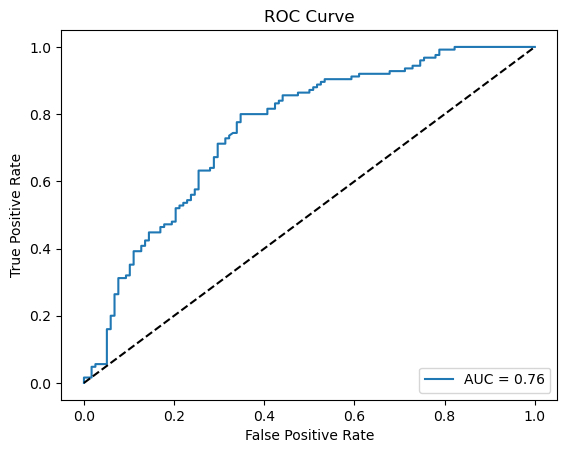

In [67]:
y_pred = hypermodel.predict(test_data_raw).ravel() 
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# plot the ROC curve
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [69]:
max((tpr+1-fpr)/2)

0.726271186440678